# Problem Statement:
## Task 2

The bit-flip code and the sign-flip code (you can find a description of both [here](https://en.wikipedia.org/wiki/Quantum_error_correction)) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

1. Build the following simple circuit to prepare the Bell state:

![Bell State generating circuit](bell-circuit.png)

2. Now add, right before the CNOT gate and for each of the two qubits, an arbitrary "error gate". By error gate, we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1-qubit unitary which can be either the identity, or the $X$ gate (bit-flip error) or the $Z$ gate (sign-flip error).
3. Encode each of the two qubits with a sign-flip or bit-flip code, in such a way that **all the possible** choices for the error gates described in (2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!
4. Test your solution by making measurements over the final state and testing that the results are in line with the expectation.


In [53]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram

from matplotlib import pyplot as plt

%matplotlib inline

import numpy as np

sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

### 1. Circuit with no errors

In [43]:
qc_1 = QuantumCircuit(2)    # Create the quantum circuit object with 2 qubits
qc_1.h(0)                   # Add a Hadamard gate on the first qubit
qc_1.cx(0,1)                # Add a CNOT gate with first qubit as control and second as target

qc_1.draw()                 # Display the circuit

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

#### Running Circuit 1

With no errors, this circuit should produce the Bell state:
$$ |\beta_{00}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} $$

Upon measuring this state, we should observe these statistics:

|**Measured State**|**Probability**|
|:----------------:|--------------:|
|00|0.5|
|01|0.0|
|10|0.0|
|11|0.5|

Output state vector:  [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


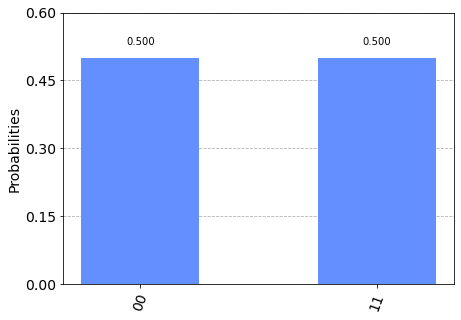

In [44]:
result = execute(qc_1,sv_sim).result()
print('Output state vector: ', result.get_statevector())

counts = result.get_counts()
plot_histogram(counts)

### 2. Circuit prone to errors, without error correction

Now, each qubit is subject to a random error before the CNOT gate. For each qubit the probability of encountering an $X$ error is $p$, the probability of encountering a $Z$ error is $p$ and thus, the probability of no error is $1-2p$.

You can adjust the value of p in the cell below:

In [45]:
p=0.3

The next cell defines a function that will add a random error gate the circuit.

* `qubit`: The index of the qubit to add the error gate to
* `prob`: The probability of the error gates occuring (assumes every error is equally likely)
* `error_gates`: A list of possible error gates (pass in the form `[quantumCircuit.gate0, ...]`)

In [46]:
def addDiscreteErrorGate(qubit, prob, error_gates):
    n = len(error_gates)
    
    # Check to make sure n*prob<=1
    if(n*prob > 1):
        raise ValueError('The entered probability is invalid, {}*prob > 1'.format(n))
    
    rand = np.random.uniform(0,1)
    #print(rand) # Debugging line
    
    # Apply error_gate[i] if the randomly generated number is between i*prob and (i+1)*prob
    for i in range(n):
        if rand < (i+1)*prob:
            error_gates[i](qubit)
            return
    

The next cell defines a circuit that implements this random error.

In [47]:
def genCircuit2(prob):
    qc = QuantumCircuit(2)
    qc.h(0)

    addDiscreteErrorGate(0,prob,[qc.x, qc.z])
    addDiscreteErrorGate(1,prob,[qc.x, qc.z])

    qc.cx(0,1)
    
    return qc

qc_2=genCircuit2(p)
qc_2.draw()

┌───┐┌───┐     
q_0: ┤ H ├┤ X ├──■──
     ├───┤└───┘┌─┴─┐
q_1: ┤ Z ├─────┤ X ├
     └───┘     └───┘

Output state vector:  [ 0.70710678+0.j -0.        +0.j -0.        +0.j  0.70710678+0.j]


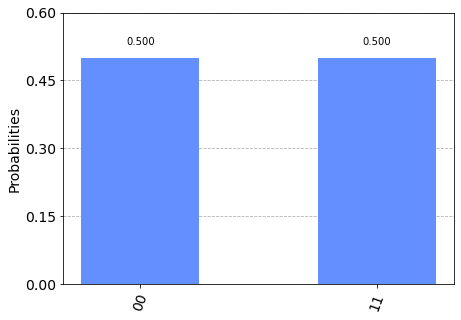

In [48]:
result = execute(qc_2,sv_sim).result()
print('Output state vector: ', result.get_statevector())

counts = result.get_counts()
plot_histogram(counts)

#### Running Circuit 2

In the above cell I displayed the output state and measurement statistics of **one instance** of Circuit 2. Since there are multiple possible ways in which the error can manifest in this circuit, it would make more sense to look at the fidelity of the circuit.

Fidelity is a measure of "how close" two quantum states are. For the pure state $|\psi\rangle$, that is the output of the error-prone circuit, and $|\phi\rangle$ that is the output of the error-free circuit, the fidelity is calculated as:
$$ F = |\langle \psi | \phi \rangle |^2 $$

We can measure the average fidelity by doing the above calculation for multiple instances of Circuit 2.

In [49]:
N = 250 # Number of trials

phi = np.array([(1.0+0.0j)/np.sqrt(2),0.0j,0.0j,(1.0+0.0j)/np.sqrt(2)])

probs = np.linspace(0,0.5,20)

F = []

for prob in probs:
    fidelities = []
    for i in range(N):
        circ = genCircuit2(prob)
        psi = execute(circ,sv_sim).result().get_statevector()
    
        fidelities.append(np.abs(np.vdot(psi,phi))**2)
    F.append(np.average(fidelities))

Given that they occur immediately after the Hadamard gate, the $X$ and $Z$ errors can only map the output onto one of the Bell states. The inner product $\langle\phi|\psi\rangle = 1$ if $|\psi\rangle=|\beta_{00}\rangle$, and $0$ otherwise and the fidelities take on the same values.

The errors that keep the output $|\beta_{00}\rangle$ are: $I_1I_2, I_1Z_2, X_1I_2,$ and $X_1Z_2 $ and so the expected fidelity for Circuit 2 can be calculated:
$$ F = (1-2p)^2 + (1-2p)p + p(1-2p) + p^2 = 1 - 2p + p^2 $$

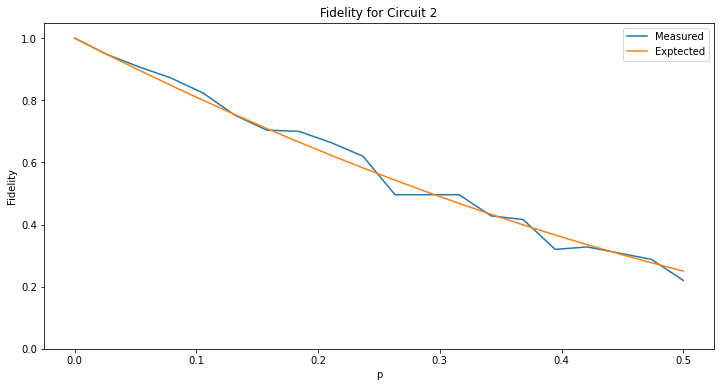

In [50]:
expected = 1 - 2*probs + probs**2 

fig = plt.figure(figsize=(12,6))

plt.title('Fidelity for Circuit 2')

plt.plot(probs,F,label='Measured')
plt.plot(probs,expected,label='Exptected')

plt.xlabel('p')
plt.ylabel('Fidelity')

plt.ylim([0,1.05])

plt.legend()

### 3. Error Correcting Code

I'll be using the Steane 7-qubit stabilizer code to do error correction because it can correct any arbitrary single-qubit error and the logical Hadamard and CNOT gates are very easy to implement in this error correction scheme.

#### Code Subspace and Syndrome Measurement
The Stabilizer generators for the code are

Name |Operator
:---:|:-------
$g_1$| $$I_1I_2I_3X_4X_5X_6X_7$$
$g_2$| $$I_1X_2X_3I_4I_5X_6X_7$$
$g_3$| $$X_1I_2X_3I_4X_5I_6X_7$$
$g_4$| $$I_1I_2I_3Z_4Z_5Z_6Z_7$$
$g_5$| $$I_1Z_2Z_3I_4I_5Z_6Z_7$$
$g_6$| $$Z_1I_2Z_3I_4Z_5I_6Z_7$$

The group of operators generated by the above generators $S=\langle g_1,g_2,g_3,g_4,g_5,g_6 \rangle$ is called the stabilizer
group for the code. The logical qubit states are unaffected by any operator $g \in S$, i.e. $g|\psi\rangle = |\psi\rangle$. That is to say, that the 'code subspace' is the vector space that is stabilized by $S$.

We can map an arbitrary 7-qubit state $|\psi\rangle$ into our code subspace by measuring the operators $g_1, \dots, g_6$. These successive measurements will project $|\psi\rangle$ into the code subspace. Each $g_i$ has eigenvalues $\pm 1$ which correspond to the projectors
$$ \frac{I\pm g_i}{\sqrt{2}} $$
respectively. We can achieve these measurements in qiskit by entangling the state $|\psi\rangle$ with 6 ancilliary qubits and measuring them as shown in the circuit below:

![Measurement Circuit](steane-measure-circuit.png)

The six qubits on top are ancillas and measuring them will project the bottom 7 qubits into the code subspace. A measurement of 0 on ancilliary qubit $i$ corresponds to measuring the eigenvalue +1 for operator $g_i$, and a measurement of 1 corresponds to measuring the eigenvalue -1. The values measured for each $g_i$ are called the '_syndrome_' measurement and will be used to correct errors.

Since each of the generators can be written as tensor products of $X$ and $I$ or $Z$ and $I$, the controlled-$g_i$ gates can be
implemented using a sequence of controlled-$X$ and controlled-$Z$ gates.

In [190]:
def getMeasurementCircuit(ancillas, logical_qubit, syndrome, name='syndrome measurement'):
    # Make sure the arguments are valid
    if not isinstance(ancillas, QuantumRegister):
        raise TypeError("'ancillas' should be a QuantumRegister")
    elif ancillas.size != 6:
        raise TypeError("'ancillas' must have 6 qubits")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit'should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(syndrome, ClassicalRegister):
        raise TypeError("'syndrome' should be a ClassicalRegister")
    elif syndrome.size != 6:
        raise TypeError("'syndrome' must have 6 bits")
    
    measure_circ = QuantumCircuit(ancillas,logical_qubit,syndrome,name='syndrome_measurement')

    for i in range(6):
        measure_circ.initialize([1,0],ancillas[i])

    measure_circ.h(ancillas)

    # Note that the register indexing starts from 0 in qiskit, as opposed to starting from 1 in the notes above

    measure_circ.cx(ancillas[0],[logical_qubit[i] for i in [3,4,5,6]]) # controlled-g1
    measure_circ.cx(ancillas[1],[logical_qubit[i] for i in [1,2,5,6]]) # controlled-g2
    measure_circ.cx(ancillas[2],[logical_qubit[i] for i in [0,2,4,6]]) # controlled-g3

    measure_circ.cz(ancillas[0],[logical_qubit[i] for i in [3,4,5,6]]) # controlled-g4
    measure_circ.cz(ancillas[1],[logical_qubit[i] for i in [1,2,5,6]]) # controlled-g5
    measure_circ.cz(ancillas[2],[logical_qubit[i] for i in [0,2,4,6]]) # controlled-g6

    measure_circ.h(ancillas)

    measure_circ.measure(ancillas,syndrome)
    
    return measure_circ

##### Initialization
We can get the logical $|0\rangle$ state by projecting the $|0\rangle^{\otimes 7}$ state into the code subspace, if the syndrome consisted of only +1 eigenvalues:

$$ |\bar{0}\rangle = 
\left(\frac{I+g_1}{\sqrt{2}}\right)
\left(\frac{I+g_2}{\sqrt{2}}\right)
\left(\frac{I+g_3}{\sqrt{2}}\right)
\left(\frac{I+g_4}{\sqrt{2}}\right)
\left(\frac{I+g_5}{\sqrt{2}}\right)
\left(\frac{I+g_6}{\sqrt{2}}\right) |0000000\rangle $$
$$ |\bar{0}\rangle = \frac{1}{\sqrt{8}} \left[
|0000000\rangle + 
|1010101\rangle + 
|0110011\rangle + 
|1100110\rangle + 
|0001111\rangle + 
|1011010\rangle + 
|0111100\rangle + 
|1101001\rangle
\right]
$$

The $|0\rangle^{\otimes 7}$ state is already in the +1 eigenspace of $g_4,g_5,$ and $g_6$ (since they are only composed of $I$ and $Z$ gates), so we need only measure $g_1, g_2, g_3$ to project this into the code space. However, there is only $1/8$ probability of measuring all three operators as +1, any other syndrome will result in a different state. We can correct for this by adding conditional $Z$ gates:

![Initialization Circuit](steane-init-circuit.png)

In [175]:
def getInitializationCircuit(ancillas, logical_qubit, syndrome, name='init logical 0'):
    # Make sure the arguments are valid
    if not isinstance(ancillas, QuantumRegister):
        raise TypeError("'ancillas' should be a QuantumRegister")
    elif ancillas.size != 3:
        raise TypeError("'ancillas' must have 6 qubits")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit'should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(syndrome, list):
        raise TypeError("'syndrome' must be a list of ClassicalRegisters")
    else:
        for s in syndrome:
            if not isinstance(s, ClassicalRegister):
                raise TypeError("'syndrome' must be a list of ClassicalRegisters")
            elif s.size != 1:
                raise TypeError("ClassicalRegisters of 'syndrome' must have 1 bit each")
        
    init_circ = QuantumCircuit(ancillas, logical_qubit, *syndrome, name=name)
    
    for i in range(3):
        init_circ.initialize([1,0], ancillas[i])
    for i in range(7):
        init_circ.initialize([1,0], logical_qubit[i])
        
    init_circ.h(ancillas)
    
    # Note that the register indexing starts from 0 in qiskit, as opposed to starting from 1 in the notes above
    
    init_circ.cx(ancillas[0],[logical_qubit[i] for i in [3,4,5,6]]) # controlled-g1
    init_circ.cx(ancillas[1],[logical_qubit[i] for i in [1,2,5,6]]) # controlled-g2
    init_circ.cx(ancillas[2],[logical_qubit[i] for i in [0,2,4,6]]) # controlled-g3
    
    init_circ.h(ancillas)
    for i in range(3):
        init_circ.measure(ancillas[i],syndrome[i])
    
    init_circ.z(logical_qubit[3]).c_if(syndrome[0],1)
    init_circ.z(logical_qubit[1]).c_if(syndrome[1],1)
    init_circ.z(logical_qubit[0]).c_if(syndrome[2],1)
    
    return init_circ

**Verifying that the circuit prepares the correct state:**

I will run this circuit using the state vector simulator and note the indices of the amplitudes that are non-zero as binary numbers. Due to the way that Qiskit formats qubit indices, qubit index '0' refers to the least significant bit (the rightmost bit in the binary number representation), which is the reverse of how I wrote the computational basis states in the $|\bar{0}\rangle$ state in the notes above.

In [176]:
a = QuantumRegister(3)
lq = QuantumRegister(7)
s = [ClassicalRegister(1),ClassicalRegister(1),ClassicalRegister(1)]

qc = getInitializationCircuit(a,lq,s)
qc.draw()

result = execute(qc,sv_sim).result()
sv =  result.get_statevector()
indices = []                     # list that holds the computational basis vector names where the amplitude is non-zero
for i in range(len(sv)):
    if sv[i] != 0:
        indices.append( ((str(bin(i)[2:]).zfill(3+7)),sv[i]) )  # store the index as a 10-bit long binary number
        
print('Number of kets in superposition: ', len(indices))
print("Kets in superposition:")
for i in indices:
    print('Ket:', i[0][0:7][::-1], '--- Amplitude:', i[1] ) # Extract the 7 left-most bits of the number, 
                                                            # reverse them (for consistency with the notes)
                                                            # and print the amplitude of the ket

print('\nsqrt[1/8] =',np.sqrt(1/8))                        # To verify the amplitudes are correct

Number of kets in superposition:  8
Kets in superposition:
Ket: 0000000 --- Amplitude: (0.35355339059327373+0j)
Ket: 0111100 --- Amplitude: (0.35355339059327373-8.659560562354934e-17j)
Ket: 1011010 --- Amplitude: (0.35355339059327373-8.659560562354934e-17j)
Ket: 1100110 --- Amplitude: (0.35355339059327373-8.659560562354934e-17j)
Ket: 1101001 --- Amplitude: (0.35355339059327373-1.2989340843532403e-16j)
Ket: 1010101 --- Amplitude: (0.35355339059327373-4.329780281177467e-17j)
Ket: 0110011 --- Amplitude: (0.35355339059327373-4.329780281177467e-17j)
Ket: 0001111 --- Amplitude: (0.35355339059327373-4.329780281177467e-17j)

sqrt[1/8] = 0.3535533905932738


These match the basis states in the logical 0:
$$ |\bar{0}\rangle = \frac{1}{\sqrt{8}} \left[
|0000000\rangle + 
|1010101\rangle + 
|0110011\rangle + 
|1100110\rangle + 
|0001111\rangle + 
|1011010\rangle + 
|0111100\rangle + 
|1101001\rangle
\right]
$$

#### Applying Gates in the Code Subspace
The logical $X$ and $Z$ gates for the Steane code are:
$$ \bar{X} = X_1X_2X_3X_4X_5X_6X_7 $$
$$ \bar{Z} = Z_1Z_2Z_3Z_4Z_5Z_6Z_7 $$

Under the stabilizer formalism, if we wish to apply a unitary operator, $U$, on our logical qubit, we have for all $g\in S$:
$$ U|\psi\rangle = Ug|\psi\rangle = UgU^\dagger U|\psi\rangle $$
So the group $USU^\dagger = \{ UgU^\dagger | g \in S \}$ stabilizes $U|\psi\rangle$. We are interested in the unitaries for which $USU^\dagger = S$ because this implies that the output of the unitary will also be in the code space, allowing us to do logical computations with them.

##### Logical Hadamard Gate
For a single qubit, the Hadamard gate has the folliwing properties:
$$ HXH^\dagger = Z $$
$$ HZH^\dagger = X $$

and so the logical Hadamard gate acting on the code space must follow the first two properties for the logical $X$ and $Z$ gates:
$$ \bar{H}\bar{X}\bar{H}^\dagger = \bar{Z} $$
$$ \bar{H}\bar{Z}\bar{H}^\dagger = \bar{X} $$

Defining
$$ \bar{H} = H_1 H_2 H_3 H_4 H_5 H_6 H_7 $$ 
clearly satisfies this property and moreover, $\bar{H}S\bar{H}^\dagger = S$ (since the generators are just permuted under this conjugation).

In [183]:
def getLogicalH(logical_qubit):
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit' should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
        
    log_h = QuantumCircuit(logical_qubit,name='Logical H')
    log_h.h(logical_qubit)
    
    return log_h

##### Logical CNOT Gate
For two logical qubits, under the stabilizer formalism, if we wish to apply a unitary operator $U$ acting on the 2-qubit state $|\psi\rangle$, for all $g_i, g_j \in S$:

$$ U|\psi\rangle = U(g_i\otimes g_j)|\psi\rangle = U(g_i\otimes g_j)U^\dagger U|\psi\rangle $$

i.e. $U|\psi\rangle$ is stabilized by $U(S\otimes S)U^\dagger = \{U(g_i\otimes g_j)U^\dagger | g_i, g_j \in S\}$ and we are interested in the unitaries where this maps back to $S\otimes S$.

As it turns out, the logical CNOT can be implemented in the Steane code subspace by taking individual CNOTS controlled by each of the qubits in the first logical register targetting the qubits sharing the same index in the second logical qubit

In [189]:
def getLogicalCNOT(control, target):
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")
    
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")

    log_cnot = QuantumCircuit(control,target,name='Logical CNOT')

    for i in range(7):
        log_cnot.cx(control[i],target[i])
    
    return log_cnot

#### Putting it together (without errors)

Let's put these components together and verify that the circuit creates the $|\beta_{00}\rangle$ state in the code subspace.

In [191]:
# The logical qubits
lq_1 = QuantumRegister(7,name='lq_1')
lq_2 = QuantumRegister(7,name='lq_2')

# Initialization Ancillas
init_ancilla = QuantumRegister(3,name='init_ancil')
init_syndrome = [ClassicalRegister(1),ClassicalRegister(1),ClassicalRegister(1)]

# Measurement Ancillas
meas_ancilla_1 = QuantumRegister(6,name='meas_ancil 1')
meas_ancilla_2 = QuantumRegister(6,name='meas_ancil 2')
meas_syndrome_1 = ClassicalRegister(6,name='meas_synd 1')
meas_syndrome_2 = ClassicalRegister(6,name='meas_synd 2')

#### Introducing Single Qubit Errors in the Circuit

#### Error Correction

#### Verifying the results